This notebook shows how to make a column density plot and a temperature slice from a 3D Cholla dataset.

In [71]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

First, we'll define a couple constants.

In [2]:
mp = 1.672622e-24 # mass of hydrogren atom, in grams
kb = 1.380658e-16 # boltzmann constant in ergs/K

Next, we'll read in the dataset. This notebook assumes you have a 3D dataset, output from a hydrodynamic simulation. I like to explicitely define the input and output directories where the data lives, and where I'd like to save my plots. (These must exist for the code to run.)

In [3]:
dnamein='./hdf5/' # directory where the file is located
dnameout='./png/' # directory where the plot will be saved

In [15]:
f = h5py.File(dnamein+'200_512_f32.h5', 'r') # open the hdf5 file for reading
head = f.attrs # read the header attributes into a structure, called head

If we'd like, we can see what attributes are attached to the file, by printing them.

In [16]:
head.keys()

<KeysViewHDF5 ['density_unit', 'dims', 'dt', 'dx', 'energy_unit', 'gamma', 'length_unit', 'mass_unit', 'n_fields', 'n_step', 't', 'time_unit', 'velocity_unit']>

Might as well see what datasets there are too, while we're at it.

In [17]:
f.keys()

<KeysViewHDF5 ['Energy', 'GasEnergy', 'density', 'momentum_x', 'momentum_y', 'momentum_z']>

Now, we'll read the attributes into variables. The "unit" provides a conversion between the simulation data in units the code was run in (the density could be in M_sun / kpc^3, for example) and cgs units.

In [18]:
gamma = head['gamma'] # ratio of specific heats
t  = head['t'] # time of this snapshot, in kyr
nx = head['dims'][0] # number of cells in the x direction
ny = head['dims'][1] # number of cells in the y direction
nz = head['dims'][2] # number of cells in the z direction
dx = head['dx'][0] # width of cell in x direction
dy = head['dx'][1] # width of cell in y direction
dz = head['dx'][2] # width of cell in z direction
l_c = head['length_unit']
t_c = head['time_unit']
m_c = head['mass_unit']
d_c = head['density_unit']
v_c = head['velocity_unit']
e_c = head['energy_unit']
p_c = e_c # pressure units are the same as energy density units, density*velocity^2/length^3

Next, we read in the datasets themselves! For this example, I want to make a density projection and a temperature slice, so I'll read in the "density" array, and the "GasEnergy" array. GasEnergy is the thermal energy density. Note that some datasets don't have a "GasEnergy" array, but it can always be calculated by subtracting the kinetic energy from the total energy.

In [19]:
d  = f['density'][:]
GE = f['GasEnergy'][:]

That's all the data we need, so let's close the file.

In [20]:
f.close()

I want to make my column density plot in units of number density (hydrogen atoms / cm^2), so I'm going to convert the mass density to number density. This requires that I assume something about the mean molecular weight. In this case, I know the simulation was run with a mean molecular weight of 1, but beware! Some simulations may have assumed something else (mu = 0.6 is common for simulations where all the gas is assumed to be ionized, for example).

In [21]:
mu = 1.0 # mean molecular weight (mu) of 1

d = d*d_c # to convert from code units to cgs, multiply by the code unit for that variable
n = d/(mu*mp) # number density, particles per cm^3

Let's see what the minimum and maximum number densities in the simulation are:

In [25]:
print("n range    = %e %e" % (np.min(n),np.max(n)))

n range    = 5.926918e-04 2.921435e+02


So our number densities range from 0.0006 hydrogen atoms per cubic cenimeter to ~300 hydrogen atoms per cubic centimeter.

To calculate the temperature, I'll use the thermal energy density, which is related to pressure by P = e_th * gamma, convert the pressure to cgs (by multiplying by the pressure unit) and assuming the ideal gas law, P = n k_b T:

In [22]:
T = GE*(gamma - 1.0)*p_c / (n*kb)

Let's pause here and see what the minimum and maximum temperatures in our simulation data are. They should be in Kelvin, so if we get something that's not between ~10 and ~1e9, we may have a hint that something has gone wrong.

In [23]:
print(np.min(T), np.max(T))

250.40210778793897 32938641.21378435


Between 250 Kelvin and 33 million Kelvin? Seems totally reasonable for astrophysics! Next, I want to create a projection of the data. A projection is a way of visualizing a three dimensional dataset in 2D, and involves integrating along one direction. Doing on-axis projections is simple, because we can use numpy's built-in 'sum' function to do the integration for us, and all that's left is to multiply by the width of the cell. In other words, with a 3D array of number densities, I can create a 2D array of column densities using the formula N = integral(n * dx) from one side of my dataset to the other.

In [24]:
pn_x = np.sum(n, axis=0)*dx*l_c 
pn_y = np.sum(n, axis=1)*dx*l_c

Let's see what the minium and maximum column density in the dataset looks like for our x projection:

In [29]:
print(np.min(pn_x), np.max(pn_x))

1.719910996232117e+18 4.957522092696697e+20


Whoa, those are big numbers! Maybe we'd be better off plotting log values.

In [31]:
log_pn_x = np.log10(pn_x)
log_pn_y = np.log10(pn_y)
print("N range    = %5.2f %5.2f" % (np.min(log_pn_x), np.max(log_pn_x)))
print("N range    = %5.2f %5.2f" % (np.min(log_pn_y), np.max(log_pn_y)))

N range    = 18.24 20.70
N range    = 17.56 20.65


Cool. I'm also going to use the minimum and maximum values to set the color scale for my column density plot.

In [32]:
pn_min=17.5
pn_max=21.0

Great! Now I'd say we're ready to make a plot.

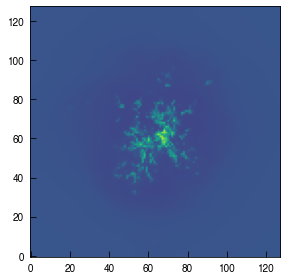

In [39]:
image = plt.imshow(log_pn_x.T, origin='lower', cmap='viridis', vmin=pn_min, vmax=pn_max)

A cloud! How beautiful. But, we'd like to know what those colors mean, after we went to all the trouble of converting the data into number densities. So let's add a colorbar. For this tutorial, I'll need to redraw the figure, too.

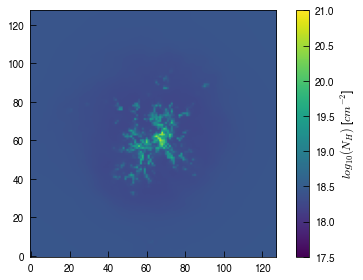

In [47]:
image = plt.imshow(log_pn_x.T, origin='lower', cmap='viridis', vmin=pn_min, vmax=pn_max)
cb = plt.colorbar(image, ticks=np.arange(pn_min, pn_max+0.5, 0.5), label='$log_{10}(N_{H})$ [$cm^{-2}$]')

That's great. Let's see what the y projection looks like!

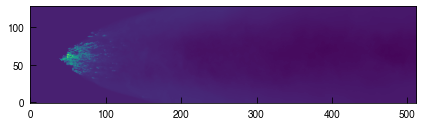

In [49]:
image = plt.imshow(log_pn_y.T, origin='lower', cmap='viridis', vmin=pn_min, vmax=pn_max)

Stunning. But, it might be nice if it was a little bigger. Maybe if I explicitely set the figure size...

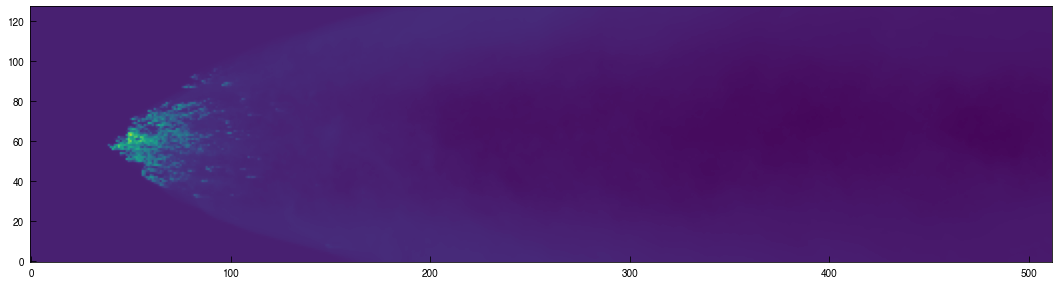

In [54]:
fig = plt.figure(figsize=(16,4))
image = plt.imshow(log_pn_y.T, origin='lower', cmap='viridis', vmin=pn_min, vmax=pn_max)
plt.show()

Now let's try making a temperature slice. Slices are a little easier than projections, since they don't involve any integration, just picking a location along one axis. Right now, T is a 3D array of temperatures for every cell. So if we select the ny/2 location for the 3rd axis, we'll get a temperature slice along the y-midplane. (Note we have to cast the index to an integer, or numpy will be grumpy.)

In [65]:
Tslice_xz = T[:,int(ny/2),:]

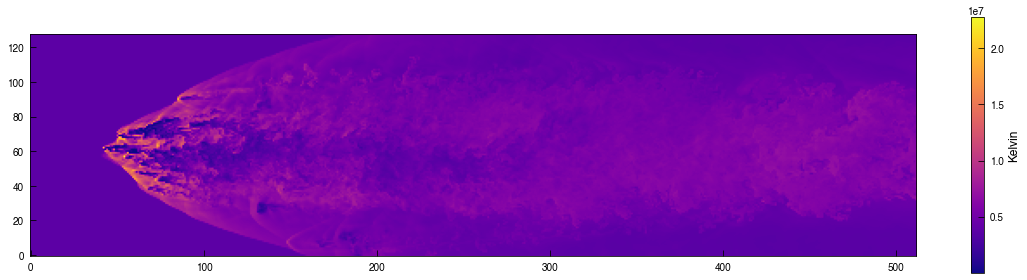

In [68]:
fig = plt.figure(figsize=(16,4))
image = plt.imshow(Tslice_xz.T, origin='lower', cmap='plasma')
cb = plt.colorbar(image, label='Kelvin')
plt.show()

Looks pretty neat! Seems like in this simulation, higher density corresponds to lower temperature. That scale doesn't give us a great sense of the range of temperatures in the data, though. Let's try a log scale again.

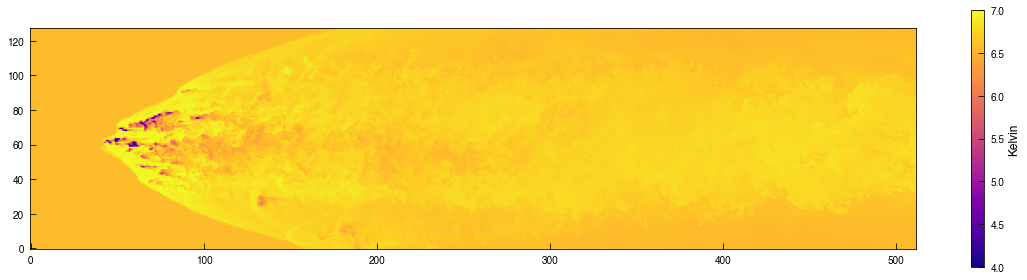

In [70]:
fig = plt.figure(figsize=(16,4))
image = plt.imshow(np.log10(Tslice_xz.T), origin='lower', cmap='plasma', vmin=4.0, vmax=7.0)
cb = plt.colorbar(image, label='Kelvin')
plt.show()